In [ ]:
!pip install opendatasets
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/arjuntejaswi/plant-village')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryan7004
Your Kaggle Key: ··········


100%|██████████| 329M/329M [00:04<00:00, 75.6MB/s]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
import matplotlib.pyplot as plt
import cv2

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-village/PlantVillage/Tomato",
    shuffle = True,
    image_size=(256,256),
    batch_size=32,
)

Found 16011 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)
classes = len(class_names)
print(classes)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
10


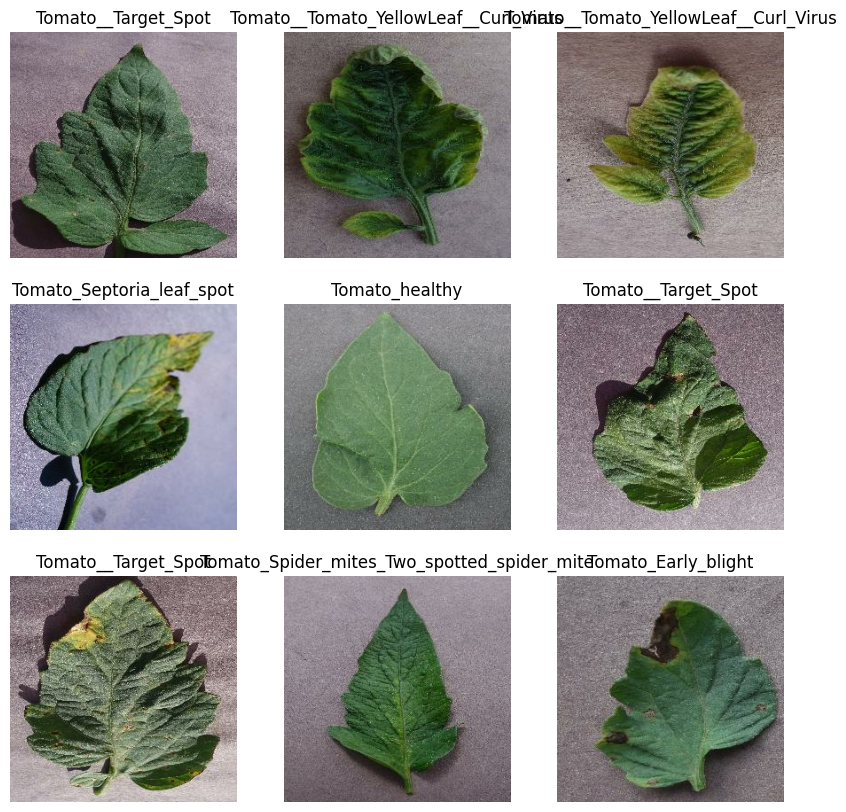

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(9):
   ax = plt.subplot(3,3,i+1)
   plt.imshow(image_batch[i].numpy().astype("uint8"))
   plt.axis('off')
   plt.title(class_names[label_batch[i]])
   # print(image_batch.shape)
   # print(label_batch.numpy())

In [ ]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [ ]:
def get_datasets(dataset,train_split=0.8,valid_split = 0.1,test_split = 0.1,shuffle=True,shuffleSize = 10000):
  if shuffle:
    dataset = dataset.shuffle(shuffle,seed = 12)
  train_size =int(0.8*len(dataset))
  val_size = int(0.1*len(dataset))
  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_datasets(dataset)
len(train_ds)

400

cache is done so that it doesn't load data on each epochs

In [ ]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

  Below is a layer to Resize and Rescale the image(if we give image to predict then it will be resized and scaled by the below layer.)

In [ ]:
img_scale_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

Apply Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

Convolutional layer model

In [ ]:
model = models.Sequential([
    img_scale_layer,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(classes,activation='softmax'),
])

model.build(input_shape = (32,256,256,3))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = 32,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
349/400 [=========================>....] - ETA: 4s - loss: 0.0909 - accuracy: 0.9672

In [ ]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 13s 36ms/step - loss: 0.2545 - accuracy: 0.9212


In [ ]:
scores

[0.25448766350746155, 0.9211669564247131]

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 400}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

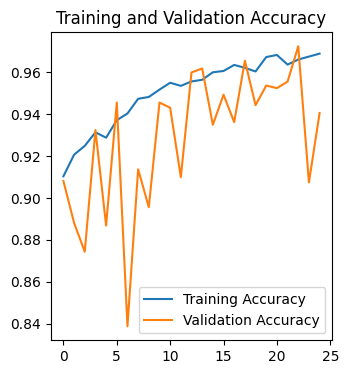

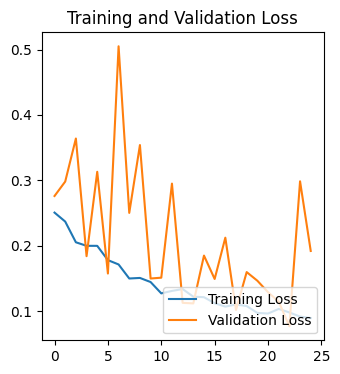

In [ ]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(range(25),train_accu,label = 'Training Accuracy')
plt.plot(range(25),val_accu,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(range(25),train_loss,label = 'Training Loss')
plt.plot(range(25),val_loss,label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 0s 46ms/step
predicted label: Tomato_Septoria_leaf_spot


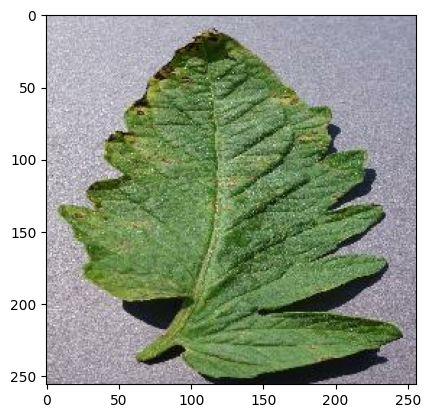

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_predict = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_predict[0])])